In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
seed = 42
np.random.seed(seed)

In [3]:
df = pd.read_csv('poster_presentation.csv', index_col=0)
print(df.shape)
print(df['Label'].value_counts())
print(df['Label_numeric'].value_counts())
X = df.iloc[:, :200].to_numpy()
y = df.iloc[:, -1].to_numpy()

(107400, 202)
Label
N    89429
Q     7999
V     6392
S     2805
F      775
Name: count, dtype: int64
Label_numeric
1    89429
2     7999
4     6392
3     2805
0      775
Name: count, dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42, stratify=y_test, shuffle=True)
print(X_train.shape, X_test.shape, X_val.shape)

(75180, 200) (21587, 200) (10633, 200)


In [5]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import torch
import random

# please do not modify this!
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps") if torch.backends.mps.is_available() else device
print(f"Device: {device}")

/home/csci5980/tirup007/.conda/envs/my_pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchsummary import summary

In [7]:
NUM_EPOCHS=100
BATCH_SIZE=100
lr = 1e-3

In [8]:
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [9]:
train_dataset = ECGDataset(torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 200), torch.tensor(y_train, dtype=torch.long))
test_dataset = ECGDataset(torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 200), torch.tensor(y_test, dtype=torch.long))
valid_dataset = ECGDataset(torch.tensor(X_val, dtype=torch.float32).reshape(-1, 1, 200), torch.tensor(y_val, dtype=torch.long))
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

75180
21587
10633


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
class ECG_CNN_LSTM(nn.Module):
    def __init__(self) -> None:
        super(ECG_CNN_LSTM, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 32, 3),
            nn.ReLU(),
            nn.MaxPool1d(2, 2)
        )
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(99*32, 200),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Unflatten(1, (1, 200))
        )
        self.lstm = nn.LSTM(200, 50, 2, batch_first=True)
        self.fc2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.final = nn.Linear(25, 5)

    def forward(self, X):
        h0 = torch.randn(2, X.shape[0], 50).to(device=X.device)
        c0 = torch.randn(2, X.shape[0], 50).to(device=X.device)
        X = self.conv1(X)
        X = self.fc1(X)
        X, _ = self.lstm(X, (h0, c0))
        X = self.fc2(X)
        return self.final(X)

In [18]:
model = ECG_CNN_LSTM()
print(model)

ECG_CNN_LSTM(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3168, out_features=200, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Unflatten(dim=1, unflattened_size=(1, 200))
  )
  (lstm): LSTM(200, 50, num_layers=2, batch_first=True)
  (fc2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50, out_features=25, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (final): Linear(in_features=25, out_features=5, bias=True)
)


In [30]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameters: ", params)

Parameters:  706133


In [19]:
def train_model(model, loss_module, optimizer, train_loader, valid_loader, device, path='models/model', epochs=30):

    training_losses = []
    validation_losses = []

    for epoch in range(epochs):

        # Set model to train mode
        model.train()

        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{epochs}", leave=False, unit='mini-batch')

        # Batch loop
        for inputs, labels in progress_bar:

            # Move input data to device (only strictly necessary if we use GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.

            optimizer.zero_grad()

            # Run the model on the input data and compute the outputs
            outputs = model(inputs)
            # outputs = outputs.squeeze(dim=1)

            # Calculate the loss
            loss = loss_module(outputs, labels)

            # Perform backpropagation
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Calculate the loss for current iteration
            running_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)


        # Set model to eval mode for validation
        model.eval()
        running_loss = 0.0
        with torch.no_grad():

            for inputs, labels in valid_loader:

                # For validation batches, calculate the output, and loss in a similar way
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                # outputs = outputs.squeeze(dim=1)
                loss = loss_module(outputs, labels)
                running_loss += loss.item()

        valid_loss = running_loss / len(valid_loader)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f},  Valid Loss: {valid_loss:.4f}')

        # Save the model's state_dict at end of each epoch
        torch.save(model.state_dict(), f'{path}-{epoch+1}.pth')

        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

    return training_losses, validation_losses

In [20]:
def plot_learning_curves(training_losses, validation_losses):

    # Plot epoch wise training and validation losses (both in the same plot)

    assert len(training_losses) == len(validation_losses)

    # YOUR CODE HERE
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend(loc="best")
    plt.show()

Epoch 1/100, Train Loss: 0.4425,  Valid Loss: 0.2415


Epoch 2/100, Train Loss: 0.2481,  Valid Loss: 0.1906


Epoch 3/100, Train Loss: 0.2089,  Valid Loss: 0.1419


Epoch 4/100, Train Loss: 0.1815,  Valid Loss: 0.1249


Epoch 5/100, Train Loss: 0.1657,  Valid Loss: 0.1107


Epoch 6/100, Train Loss: 0.1524,  Valid Loss: 0.1013


Epoch 7/100, Train Loss: 0.1441,  Valid Loss: 0.0952


Epoch 8/100, Train Loss: 0.1364,  Valid Loss: 0.0961


Epoch 9/100, Train Loss: 0.1320,  Valid Loss: 0.0818


Epoch 10/100, Train Loss: 0.1263,  Valid Loss: 0.0855


Epoch 11/100, Train Loss: 0.1198,  Valid Loss: 0.0819


Epoch 12/100, Train Loss: 0.1186,  Valid Loss: 0.0828


Epoch 13/100, Train Loss: 0.1102,  Valid Loss: 0.0772


Epoch 14/100, Train Loss: 0.1080,  Valid Loss: 0.0719


Epoch 15/100, Train Loss: 0.1060,  Valid Loss: 0.0721


Epoch 16/100, Train Loss: 0.1035,  Valid Loss: 0.0671


Epoch 17/100, Train Loss: 0.1002,  Valid Loss: 0.0654


Epoch 18/100, Train Loss: 0.0977,  Valid Loss: 0.0675


Epoch 19/100, Train Loss: 0.0911,  Valid Loss: 0.0688


Epoch 20/100, Train Loss: 0.0933,  Valid Loss: 0.0644


Epoch 21/100, Train Loss: 0.0879,  Valid Loss: 0.0631


Epoch 22/100, Train Loss: 0.0904,  Valid Loss: 0.0635


Epoch 23/100, Train Loss: 0.0858,  Valid Loss: 0.0617


Epoch 24/100, Train Loss: 0.0856,  Valid Loss: 0.0586


Epoch 25/100, Train Loss: 0.0834,  Valid Loss: 0.0662


Epoch 26/100, Train Loss: 0.0810,  Valid Loss: 0.0661


Epoch 27/100, Train Loss: 0.0801,  Valid Loss: 0.0610


Epoch 28/100, Train Loss: 0.0806,  Valid Loss: 0.0640


Epoch 29/100, Train Loss: 0.0791,  Valid Loss: 0.0593


Epoch 30/100, Train Loss: 0.0752,  Valid Loss: 0.0573


Epoch 31/100, Train Loss: 0.0769,  Valid Loss: 0.0571


Epoch 32/100, Train Loss: 0.0752,  Valid Loss: 0.0559


Epoch 33/100, Train Loss: 0.0747,  Valid Loss: 0.0547


Epoch 34/100, Train Loss: 0.0749,  Valid Loss: 0.0603


Epoch 35/100, Train Loss: 0.0731,  Valid Loss: 0.0589


Epoch 36/100, Train Loss: 0.0725,  Valid Loss: 0.0556


Epoch 37/100, Train Loss: 0.0707,  Valid Loss: 0.0600


Epoch 38/100, Train Loss: 0.0720,  Valid Loss: 0.0521


Epoch 39/100, Train Loss: 0.0696,  Valid Loss: 0.0531


Epoch 40/100, Train Loss: 0.0691,  Valid Loss: 0.0561


Epoch 41/100, Train Loss: 0.0678,  Valid Loss: 0.0509


Epoch 42/100, Train Loss: 0.0692,  Valid Loss: 0.0562


Epoch 43/100, Train Loss: 0.0668,  Valid Loss: 0.0577


Epoch 44/100, Train Loss: 0.0670,  Valid Loss: 0.0508


Epoch 45/100, Train Loss: 0.0667,  Valid Loss: 0.0511


Epoch 46/100, Train Loss: 0.0650,  Valid Loss: 0.0536


Epoch 47/100, Train Loss: 0.0643,  Valid Loss: 0.0514


Epoch 48/100, Train Loss: 0.0641,  Valid Loss: 0.0520


Epoch 49/100, Train Loss: 0.0643,  Valid Loss: 0.0518


Epoch 50/100, Train Loss: 0.0641,  Valid Loss: 0.0521


Epoch 51/100, Train Loss: 0.0647,  Valid Loss: 0.0497


Epoch 52/100, Train Loss: 0.0608,  Valid Loss: 0.0559


Epoch 53/100, Train Loss: 0.0641,  Valid Loss: 0.0534


Epoch 54/100, Train Loss: 0.0580,  Valid Loss: 0.0560


Epoch 55/100, Train Loss: 0.0584,  Valid Loss: 0.0533


Epoch 56/100, Train Loss: 0.0627,  Valid Loss: 0.0556


Epoch 57/100, Train Loss: 0.0633,  Valid Loss: 0.0555


Epoch 58/100, Train Loss: 0.0610,  Valid Loss: 0.0525


Epoch 59/100, Train Loss: 0.0572,  Valid Loss: 0.0575


Epoch 60/100, Train Loss: 0.0583,  Valid Loss: 0.0606


Epoch 61/100, Train Loss: 0.0594,  Valid Loss: 0.0566


Epoch 62/100, Train Loss: 0.0590,  Valid Loss: 0.0539


Epoch 63/100, Train Loss: 0.0596,  Valid Loss: 0.0604


Epoch 64/100, Train Loss: 0.0571,  Valid Loss: 0.0621


Epoch 65/100, Train Loss: 0.0581,  Valid Loss: 0.0579


Epoch 66/100, Train Loss: 0.0528,  Valid Loss: 0.0545


Epoch 67/100, Train Loss: 0.0561,  Valid Loss: 0.0647


Epoch 68/100, Train Loss: 0.0590,  Valid Loss: 0.0556


Epoch 69/100, Train Loss: 0.0564,  Valid Loss: 0.0554


Epoch 70/100, Train Loss: 0.0553,  Valid Loss: 0.0561


Epoch 71/100, Train Loss: 0.0553,  Valid Loss: 0.0551


Epoch 72/100, Train Loss: 0.0547,  Valid Loss: 0.0528


Epoch 73/100, Train Loss: 0.0541,  Valid Loss: 0.0586


Epoch 74/100, Train Loss: 0.0527,  Valid Loss: 0.0593


Epoch 75/100, Train Loss: 0.0559,  Valid Loss: 0.0547


Epoch 76/100, Train Loss: 0.0549,  Valid Loss: 0.0578


Epoch 77/100, Train Loss: 0.0533,  Valid Loss: 0.0525


Epoch 78/100, Train Loss: 0.0543,  Valid Loss: 0.0595


Epoch 79/100, Train Loss: 0.0538,  Valid Loss: 0.0638


Epoch 80/100, Train Loss: 0.0528,  Valid Loss: 0.0589


Epoch 81/100, Train Loss: 0.0526,  Valid Loss: 0.0529


Epoch 82/100, Train Loss: 0.0541,  Valid Loss: 0.0515


Epoch 83/100, Train Loss: 0.0503,  Valid Loss: 0.0533


Epoch 84/100, Train Loss: 0.0521,  Valid Loss: 0.0625


Epoch 85/100, Train Loss: 0.0528,  Valid Loss: 0.0553


Epoch 86/100, Train Loss: 0.0520,  Valid Loss: 0.0641


Epoch 87/100, Train Loss: 0.0528,  Valid Loss: 0.0580


Epoch 88/100, Train Loss: 0.0513,  Valid Loss: 0.0622


Epoch 89/100, Train Loss: 0.0515,  Valid Loss: 0.0578


Epoch 90/100, Train Loss: 0.0512,  Valid Loss: 0.0540


Epoch 91/100, Train Loss: 0.0507,  Valid Loss: 0.0524


Epoch 92/100, Train Loss: 0.0490,  Valid Loss: 0.0543


Epoch 93/100, Train Loss: 0.0520,  Valid Loss: 0.0546


Epoch 94/100, Train Loss: 0.0489,  Valid Loss: 0.0611


Epoch 95/100, Train Loss: 0.0479,  Valid Loss: 0.0648


Epoch 96/100, Train Loss: 0.0518,  Valid Loss: 0.0592


Epoch 97/100, Train Loss: 0.0471,  Valid Loss: 0.0590


Epoch 98/100, Train Loss: 0.0487,  Valid Loss: 0.0650


Epoch 99/100, Train Loss: 0.0490,  Valid Loss: 0.0559


Epoch 100/100, Train Loss: 0.0528,  Valid Loss: 0.0648


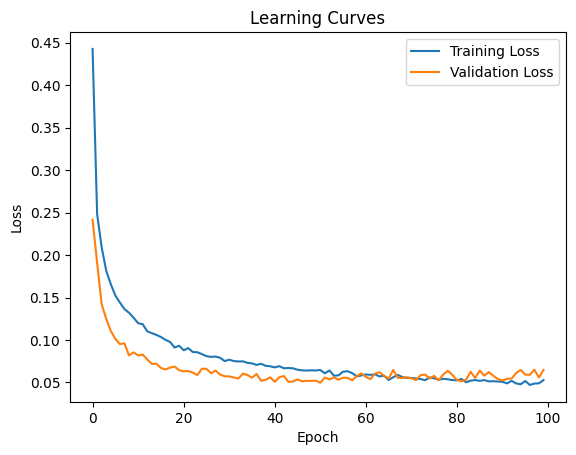

In [21]:
model.to(device)

loss_module = nn.CrossEntropyLoss()

# You can use '0.0001' as learning rate for the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


training_losses, validation_losses = train_model(model, loss_module, optimizer, train_dataloader, valid_dataloader, device, "models/cnnlstm", NUM_EPOCHS)
plot_learning_curves(training_losses, validation_losses)

In [22]:
def test_model(model, test_loader, loss_module):

    true_labels = []
    predicted_labels = []

    running_correct = 0
    running_loss=0.0
    # Set model to eval mode
    model.eval()

    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_module(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_correct += (predicted==labels).sum().item()

            true_labels.extend(labels.cpu().numpy().astype(int))
            predicted_labels.extend(predicted.cpu().numpy())
        
        accuracy = (running_correct/len(true_labels)) * 100
        loss = (running_loss/len(true_labels))
    return true_labels, predicted_labels, accuracy, loss


In [23]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap=plt.cm.Blues)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(np.arange(len(classes)) + 0.5, classes)
    plt.yticks(np.arange(len(classes)) + 0.5, classes)
    plt.show()

In [25]:
model_opt = ECG_CNN_LSTM()
model_opt.load_state_dict(torch.load('models/cnnlstm-44.pth'))
model_opt.to(device)
true_labels, predicted_labels, test_acc, test_loss = test_model(model_opt, test_dataloader, loss_module)

assert(len(true_labels) == len(predicted_labels))

Test Accuracy: 98.66586371427249
 Test Loss: 0.0005161889245198088
              precision    recall  f1-score   support

           0     0.9524    0.7742    0.8541       155
           1     0.9867    0.9984    0.9925     17975
           2     0.9981    0.9863    0.9922      1608
           3     0.9736    0.7199    0.8277       564
           4     0.9787    0.9658    0.9722      1285

    accuracy                         0.9867     21587
   macro avg     0.9779    0.8889    0.9277     21587
weighted avg     0.9865    0.9867    0.9860     21587



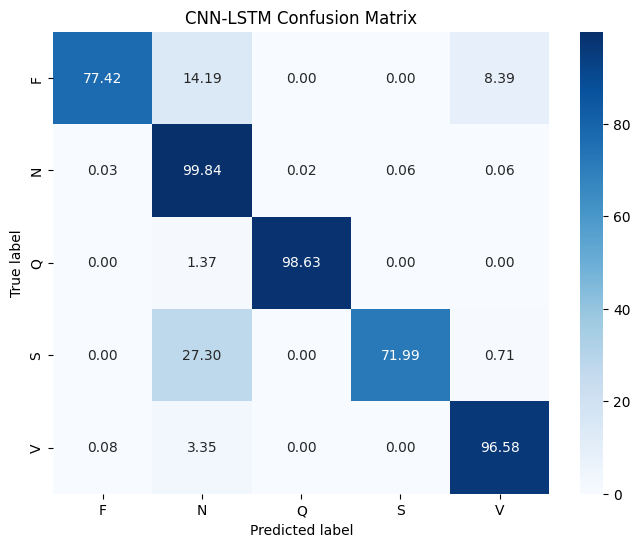

In [28]:
print(f"Test Accuracy: {test_acc}\n Test Loss: {test_loss}")
print(classification_report(true_labels, predicted_labels, digits=4))
plot_confusion_matrix(confusion_matrix(true_labels, predicted_labels), np.array(['F','N','Q','S','V']), "CNN-LSTM Confusion Matrix")